In [1]:
!pip install datasets transformers evaluate imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 4.9 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
from datasets import load_dataset

health_fact = load_dataset('health_fact')

Generating train split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
health_fact.set_format(type="pandas")
df = health_fact["train"][:]
df.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,


In [6]:
def label_int2str(row):
    if row == -1:
        return 'invalid'
    return health_fact["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

In [7]:
df.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,label_name
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,",false
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health",mixture
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer",mixture
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health",true
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,,true


Text(0.5, 1.0, 'Frequency of Classes')

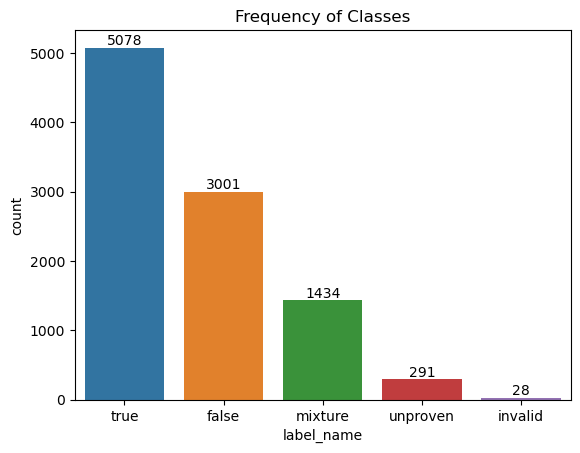

In [8]:
# df["label_name"].value_counts(ascending=True).plot.barh()

ax = sns.countplot(x='label_name', data=df, order = df['label_name'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title("Frequency of Classes")

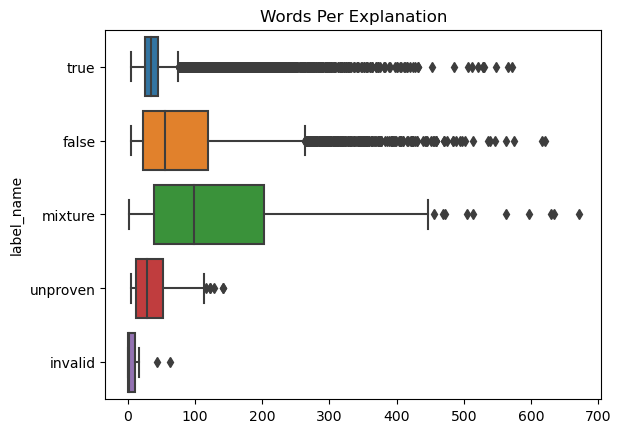

In [9]:
df['Words Per Explanation'] = df['explanation'].str.split().apply(len)
sns.boxplot(x=df['Words Per Explanation'], y=df['label_name'], data=df, order = df['label_name'].value_counts().index)
plt.title("Words Per Explanation")
plt.xlabel("")
plt.show()

In [10]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
# checkpoint = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenized_explanations = tokenizer(health_fact["train"]["explanation"], max_length=512, truncation=True, padding=True, return_tensors="pt")

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [12]:
health_fact.reset_format()

In [13]:
def tokenize(batch):
    return tokenizer(batch['explanation'], truncation=True, padding=True)

In [14]:
health_fact_encoded = health_fact.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [15]:
print(health_fact_encoded["train"].column_names)

['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects', 'input_ids', 'token_type_ids', 'attention_mask']


In [16]:
import torch
from transformers import AutoModel

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [19]:
health_fact_encoded.set_format('torch', columns=["input_ids", "attention_mask", "label"])

In [20]:
health_fact_hidden = health_fact_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/10 [00:00<?, ?ba/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 11.72 GiB (GPU 0; 15.90 GiB total capacity; 9.04 GiB already allocated; 5.97 GiB free; 9.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF